In [1]:
if (!requireNamespace("MASS", quietly=TRUE)) {
  install.packages("MASS", repos="https://cloud.r-project.org")
}
if (!requireNamespace("dglm", quietly=TRUE)) {
  install.packages("dglm", repos="https://cloud.r-project.org")
}

In [2]:
library(MASS)
library(dglm)

In [3]:
# Simulate heteroscedastic NB data
set.seed(42)
n <- 500
x <- runif(n, 0, 10)
z <- runif(n, 0, 10)

# True parameters for mean and (log-)dispersion
beta0 <- 0.5
beta1 <- 0.1
gamma0 <- -1.0
gamma1 <-  0.3

# Linear predictors
eta_mu <- beta0 + beta1 * x
eta_disp <- gamma0 + gamma1 * z

# Canonical links
mu_i <- exp(eta_mu)       # E[Y_i]
theta_i <- exp(eta_disp)  # NB shape ≡ size parameter

# NB parameterization: size = theta_i, prob = theta_i/(theta_i + mu_i)
size_i <- theta_i
prob_i <- size_i / (size_i + mu_i)

# Draw counts
y <- rnbinom(n, size = size_i, prob = prob_i)

df <- data.frame(y = y, x = x, z = z)

In [4]:
# Fit the Negative-Binomial DGLM
#  formula = mean model: (NB mean, log-link): y ~ x
#  dformula = dispersion model: (log-dispersion link): ~ z
#  family = negative.binomial(theta = 1) (seed scale=1)

nb_dglm <- dglm(
  formula = y ~ x,
  dformula = ~ z,
  family = negative.binomial(theta = 1),
  data = df
)

In [5]:
# Summaries
cat("--- Mean (NB) Submodel ---\n")
print(summary(nb_dglm))

cat("\n--- Dispersion  Submodel ---\n")
print(summary(nb_dglm$dispersion.fit))

--- Mean (NB) Submodel ---

Call: dglm(formula = y ~ x, dformula = ~z, family = negative.binomial(theta = 1), 
    data = df)

Mean Coefficients:
             Estimate Std. Error  t value     Pr(>|t|)
(Intercept) 0.4082464 0.11278489 3.619690 3.251216e-04
x           0.1061652 0.01635981 6.489389 2.084571e-10
(Dispersion Parameters for Negative Binomial(1) family estimated as below )

    Scaled Null Deviance: 542.1853 on 499 degrees of freedom
Scaled Residual Deviance: 500 on 498 degrees of freedom

Dispersion Coefficients:
              Estimate Std. Error   z value     Pr(>|z|)
(Intercept)  0.6422690 0.12367480  5.193208 2.067011e-07
z           -0.1474883 0.02182603 -6.757451 1.404401e-11
(Dispersion parameter for Gamma family taken to be 2 )

    Scaled Null Deviance: 692.6289 on 499 degrees of freedom
Scaled Residual Deviance: 646.4779 on 498 degrees of freedom

Minus Twice the Log-Likelihood: 2064.116 
Number of Alternating Iterations: 4 

--- Dispersion  Submodel ---

Call:
dgl

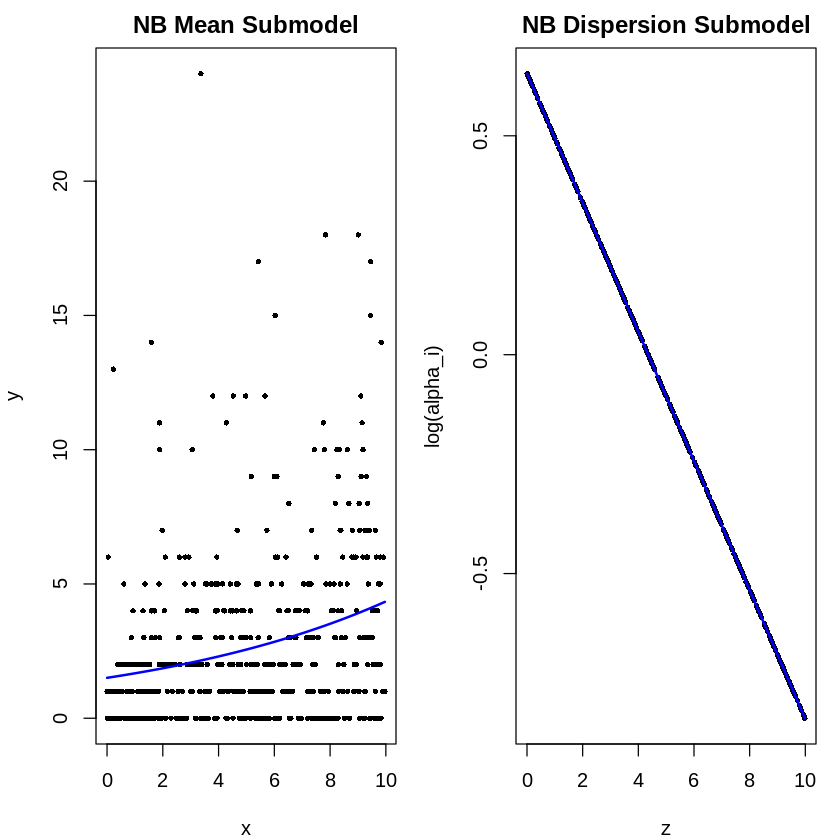

In [6]:
# Diagnostic plots
par(mfrow = c(1, 2), mar = c(4, 4, 2, 1))

# Mean fit: observed vs. fitted
plot(
    x,
    y,
    pch = 16,
    cex = 0.6,
    xlab = "x",
    ylab = "y",
    main = "NB Mean Submodel"
)

xx <- seq(min(x), max(x), length = 200)
lines(
    xx,
    predict(
        nb_dglm,
        newdata = data.frame(x = xx),
        type = "response"
    ),
    col = "blue",
    lwd = 2
)

# Dispersion fit: estimated log-dispersion vs. z
disp_link_z <- predict(
    nb_dglm$dispersion.fit,
    newdata = data.frame(z = z),
    type = "link"
)

plot(
    z,
    disp_link_z,
    pch = 16,
    cex = 0.6,
    xlab = "z",
    ylab = "log(alpha_i)",
    main = "NB Dispersion Submodel"
)

zz <- seq(min(z), max(z), length = 200)
lines(
    zz,
    predict(
        nb_dglm$dispersion.fit,
        newdata = data.frame(z = zz),
        type = "link"
    ),
    col = "blue",
    lwd = 2
)